# Лабораторная работа №7 (Проведение исследований моделями семантической сегментации) 

# 1.	Выбор начальных условий

Для выполнения данной работы используется [Cambridge-Driving Labeled Video Database](https://www.kaggle.com/datasets/carlolepelaars/camvid) датасет.

Он может быть полезен при использовании в автономном транспорте или для видеонаблюдения на улице.

В качестве метрики будем использовать Intersection‑over‑Union. Это отношение площади пересечения предсказанной маски P и истинной маски G к площади их объединения.

Загрузим датасет с kaggle

In [4]:
import kagglehub

path = kagglehub.dataset_download("carlolepelaars/camvid")

print("Path to dataset files:", path)

Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/carlolepelaars/camvid/versions/2


Загрузим библиотеку segmentation_models_pytorch для работы с сегментационными моделями

In [2]:
%pip install imantics segmentation_models_pytorch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


# 2. Создание бейзлайна и оценка качества
## 2.a. Обучение моделей (Unet и Segformer) из segmentation_models на выбранном наборе данных

Загрузим необходимые библиотеки для дальнейшей работы

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp

In [136]:
batch_size = 4
num_classes = 32
lr = 0.001
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Выделим все уникальные цвета и дадим им номера классов

In [19]:
def get_unique_colors(mask_dir):
    unique_colors = set()
    mask_files = os.listdir(mask_dir)
    
    for mask_file in mask_files:
        mask_path = os.path.join(mask_dir, mask_file)
        mask = Image.open(mask_path).convert("RGB")
        mask_np = np.array(mask)
        unique_colors.update(set(map(tuple, mask_np.reshape(-1, 3))))
    
    return unique_colors

unique_colors = get_unique_colors(os.path.join(path, "CamVid", "train_labels"))

Нормализуем вектора уникальных цветов

In [20]:
normalized_unique_colors = [(i[0]/(np.sqrt(i[0]**2+i[1]**2+i[2]**2)), i[1]/(np.sqrt(i[0]**2+i[1]**2+i[2]**2)), i[2]/(np.sqrt(i[0]**2+i[1]**2+i[2]**2))) if i[0]**2+i[1]**2+i[2]**2 != 0 else (0, 0, 0) for i in unique_colors]
print(normalized_unique_colors)
print(len(normalized_unique_colors))

[(0.7071067811865476, 0.0, 0.7071067811865476), (0.7071067811865475, 0.7071067811865475, 0.0), (0.6666666666666666, 0.6666666666666666, 0.3333333333333333), (1.0, 0.0, 0.0), (0.5773502691896258, 0.5773502691896258, 0.5773502691896258), (0.8164965809277261, 0.4082482904638631, 0.4082482904638631), (0.6666666666666666, 0.3333333333333333, 0.6666666666666666), (0.48507125007266594, 0.48507125007266594, 0.7276068751089989), (0.5547001962252291, 0.0, 0.8320502943378437), (0.0, 0.8944271909999159, 0.4472135954999579), (0.31622776601683794, 0.9486832980505138, 0.0), (0.0, 0.5547001962252291, 0.8320502943378437), (0.2672612419124244, 0.8017837257372732, 0.5345224838248488), (0.4082482904638631, 0.8164965809277261, 0.4082482904638631), (0.2672612419124244, 0.5345224838248488, 0.8017837257372732), (0.0, 0.7071067811865475, 0.7071067811865475), (0.0, 0.0, 1.0), (0.7071067811865475, 0.7071067811865475, 0.0), (0, 0, 0), (0.0, 0.0, 1.0), (0.4082482904638631, 0.4082482904638631, 0.8164965809277261), 

Функции для преобразования изображения в массив классов и обратно

In [16]:
def color2class(mask, normalized_unique_colors):
    mask = mask.transpose(1, 2, 0)
    
    height, width, _ = mask.shape
    mask_rgb = mask.reshape(-1, 3)  # [H*W, 3]
    unique_colors = np.array(normalized_unique_colors)
    dists = np.linalg.norm(mask_rgb[:, np.newaxis, :] - unique_colors, axis=-1)
    result = np.argmin(dists, axis=-1)
    return result.reshape(height, width)

def class2color(class_mask, unique_colors):
    height, width = class_mask.shape
    color_mask = np.zeros((height, width, 3))
    
    for class_index, color in enumerate(unique_colors):
        color_mask[class_mask == class_index] = color
    
    return color_mask

Класс кастомного датасета с возможностью применений трансформаций и аугментаций над данными

In [14]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, aug=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.aug = aug
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        
        if self.aug:
            image_np = np.array(image)
            mask_np = np.array(mask)
            
            augmented = self.aug(image=image_np, mask=mask_np)
            image_np = augmented['image']
            mask_np = augmented['mask']
            
            image = Image.fromarray(image_np)
            mask = Image.fromarray(mask_np)
        
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask_np = np.array(mask)
        else:
            mask_np = np.array(mask)
        
        mask_np = color2class(mask_np, normalized_unique_colors)
        
        mask = torch.from_numpy(mask_np).long()
        
        return image, mask


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = SegmentationDataset(os.path.join(path, "CamVid", "train"), os.path.join(path, "CamVid", "train_labels"), transform=transform, mask_transform=mask_transform)
val_dataset = SegmentationDataset(os.path.join(path, "CamVid", "val"), os.path.join(path, "CamVid", "val_labels"), transform=transform, mask_transform=mask_transform)
test_dataset = SegmentationDataset(os.path.join(path, "CamVid", "test"), os.path.join(path, "CamVid", "test_labels"), transform=transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
def print_image_and_mask_as_numpy(data_loader):
    batch = next(iter(data_loader))
    images, masks = batch
    
    idx = random.randint(0, len(images) - 1)
    
    image = images[idx]
    mask = masks[idx]
    
    image_np = image.permute(1, 2, 0).cpu().numpy()
    mask_np = mask.cpu().numpy()
    
    print("Mask as numpy array:")
    print(mask_np)

print_image_and_mask_as_numpy(train_loader)

Mask as numpy array:
[[ 3  3  3 ...  4  4  4]
 [ 3  3  3 ...  4  4  4]
 [ 3  3  3 ...  4  4  4]
 ...
 [16 16 16 ...  6  6  6]
 [16 16 16 ...  6  6  6]
 [16 16 16 ...  6  6  6]]


Функции для отображения изображения и масок и для отображения случайной выборки из train_loader

In [26]:
def display_sample(image, true_mask, reconstructed_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    image = image.permute(1, 2, 0)

    axes[0].imshow(image)
    axes[0].set_title("Image")

    axes[1].imshow(true_mask)
    axes[1].set_title("True Mask")

    axes[2].imshow(reconstructed_mask)
    axes[2].set_title("Reconstructed Mask")
    
    for ax in axes:
        ax.axis('off')
    
    plt.show()

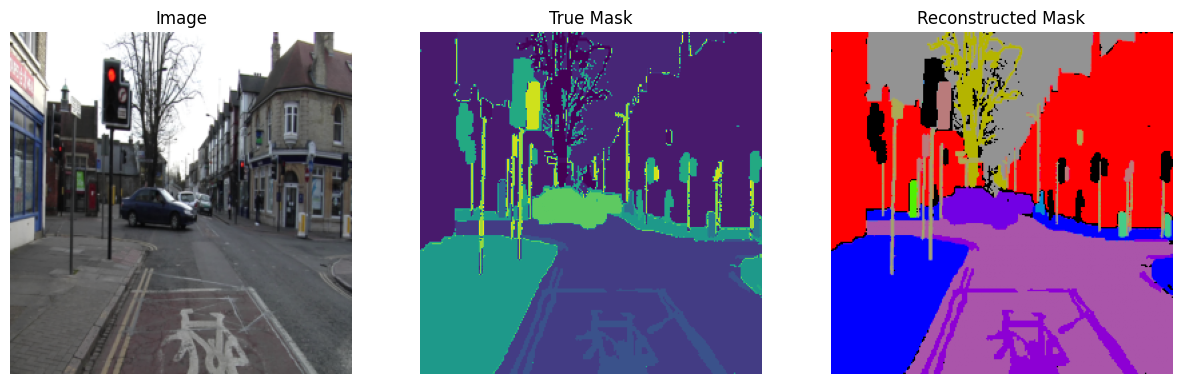

In [ ]:
import matplotlib.pyplot as plt
import random
import torch

def show_random_sample_from_loader(train_loader, normalized_unique_colors):
    batch = next(iter(train_loader))
    images, class_masks = batch

    idx = random.randint(0, len(images) - 1)
    image = images[idx]
    class_mask = class_masks[idx]

    reconstructed_mask = class2color(class_mask.numpy(), normalized_unique_colors)
    
    display_sample(image, class_mask.numpy(), reconstructed_mask)

show_random_sample_from_loader(train_loader, normalized_unique_colors)

Создаем Unet модель

In [317]:
model = smp.Unet(
    encoder_name='resnet34',   
    encoder_weights='imagenet',
    in_channels=3,             
    classes=num_classes,       
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

Функция для вычисления IoU

In [22]:
def compute_iou(pred_mask, true_mask, num_classes):
    iou_per_class = []
    
    for cls in range(num_classes):
        intersection = np.logical_and(pred_mask == cls, true_mask == cls).sum()
        union = np.logical_or(pred_mask == cls, true_mask == cls).sum()
        
        if union == 0:
            iou = np.nan
        else:
            iou = intersection / union
        
        iou_per_class.append(iou)
    
    mean_iou = np.nanmean(iou_per_class)
    
    return mean_iou

#### Unet

Обучение модели. В качестве оптимизатора используем Adam, в качестве функции потерь - CrossEntropyLoss

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import segmentation_models_pytorch as smp

def train_model(model, train_loader, val_loader, optimizer=None, criterion=None, num_epochs=10, lr=0.001, device='cuda', return_iou=False):
    if optimizer is None:
        optimizer = Adam(model.parameters(), lr=lr)
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    model.to(device)
    best_iou = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_iou = []

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            iou_preds = preds.cpu()
            iou_masks = masks.cpu()
            iou_score = compute_iou(iou_preds, iou_masks, 32)
            train_iou.append(iou_score)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_iou = np.mean(train_iou)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training IoU: {epoch_iou:.4f}')

        model.eval()
        val_loss = 0.0
        val_iou = []
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

                preds = torch.argmax(outputs, dim=1)
                iou_preds = preds.cpu()
                iou_masks = masks.cpu()
                iou_score = compute_iou(iou_preds, iou_masks, 32)
                val_iou.append(iou_score)

        val_loss /= len(val_loader.dataset)
        val_iou_score = np.mean(val_iou)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou_score:.4f}')
        
        if val_iou_score > best_iou:
            best_iou = val_iou_score
    
    if return_iou:
        return model, best_iou
    return model



In [320]:
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=32,
)

trained_model = train_model(model, train_loader, val_loader)

Epoch 1/10, Training Loss: 2.1016, Training IoU: 0.0928
Epoch 1/10, Validation Loss: 1.3393, Validation IoU: 0.1090
Epoch 2/10, Training Loss: 1.1129, Training IoU: 0.1280
Epoch 2/10, Validation Loss: 1.0427, Validation IoU: 0.1216
Epoch 3/10, Training Loss: 0.8907, Training IoU: 0.1370
Epoch 3/10, Validation Loss: 0.8977, Validation IoU: 0.1515
Epoch 4/10, Training Loss: 0.7650, Training IoU: 0.1688
Epoch 4/10, Validation Loss: 0.7991, Validation IoU: 0.1601
Epoch 5/10, Training Loss: 0.7289, Training IoU: 0.1857
Epoch 5/10, Validation Loss: 0.7328, Validation IoU: 0.1849
Epoch 6/10, Training Loss: 0.6630, Training IoU: 0.2080
Epoch 6/10, Validation Loss: 0.6777, Validation IoU: 0.1895
Epoch 7/10, Training Loss: 0.6081, Training IoU: 0.2228
Epoch 7/10, Validation Loss: 0.6638, Validation IoU: 0.2040
Epoch 8/10, Training Loss: 0.5629, Training IoU: 0.2344
Epoch 8/10, Validation Loss: 0.7705, Validation IoU: 0.1967
Epoch 9/10, Training Loss: 0.6208, Training IoU: 0.2270
Epoch 9/10, Vali

Посмотрим на примеры предсказаний

In [24]:
import matplotlib.pyplot as plt
import random
import torch

def show_random_prediction(val_loader, model, normalized_unique_colors, device='cuda'):
    model.eval()

    batch = next(iter(val_loader))
    images, class_masks = batch

    idx = random.randint(0, len(images) - 1)
    image = images[idx].to(device)
    true_mask = class_masks[idx]

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        pred_classes = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    true_mask_color = class2color(true_mask.numpy(), normalized_unique_colors)
    pred_mask_color = class2color(pred_classes, normalized_unique_colors)

    display_sample(image.cpu(), true_mask_color, pred_mask_color)

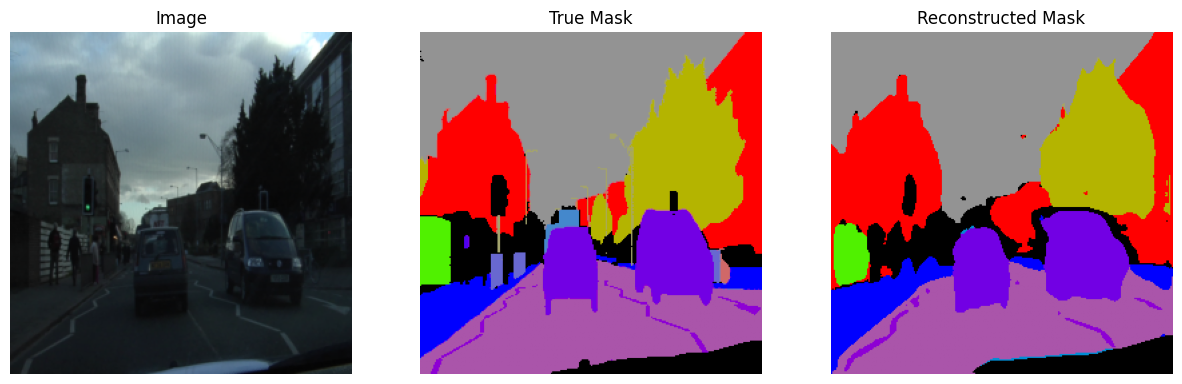

In [ ]:
show_random_prediction(val_loader, trained_model, normalized_unique_colors)


Значение IoU невелико, однако видно, что в целом модель неплохо стремится к правильной маске.

##### Segformer

Аналогично обучим Segformer

In [331]:
model = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=32,
)

trained_segformer_model = train_model(model, train_loader, val_loader)

/home/jupyter/.local/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading mit_b0 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)


Epoch 1/10, Training Loss: 1.2993, Training IoU: 0.1228
Epoch 1/10, Validation Loss: 0.8037, Validation IoU: 0.1655
Epoch 2/10, Training Loss: 0.7409, Training IoU: 0.1818
Epoch 2/10, Validation Loss: 0.6869, Validation IoU: 0.1851
Epoch 3/10, Training Loss: 0.6223, Training IoU: 0.2304
Epoch 3/10, Validation Loss: 0.6294, Validation IoU: 0.2104
Epoch 4/10, Training Loss: 0.5535, Training IoU: 0.2631
Epoch 4/10, Validation Loss: 0.5583, Validation IoU: 0.2308
Epoch 5/10, Training Loss: 0.4898, Training IoU: 0.3000
Epoch 5/10, Validation Loss: 0.5361, Validation IoU: 0.2508
Epoch 6/10, Training Loss: 0.4632, Training IoU: 0.3180
Epoch 6/10, Validation Loss: 0.5183, Validation IoU: 0.2612
Epoch 7/10, Training Loss: 0.4656, Training IoU: 0.3277
Epoch 7/10, Validation Loss: 0.5245, Validation IoU: 0.2492
Epoch 8/10, Training Loss: 0.4262, Training IoU: 0.3471
Epoch 8/10, Validation Loss: 0.5140, Validation IoU: 0.2598
Epoch 9/10, Training Loss: 0.3968, Training IoU: 0.3629
Epoch 9/10, Vali

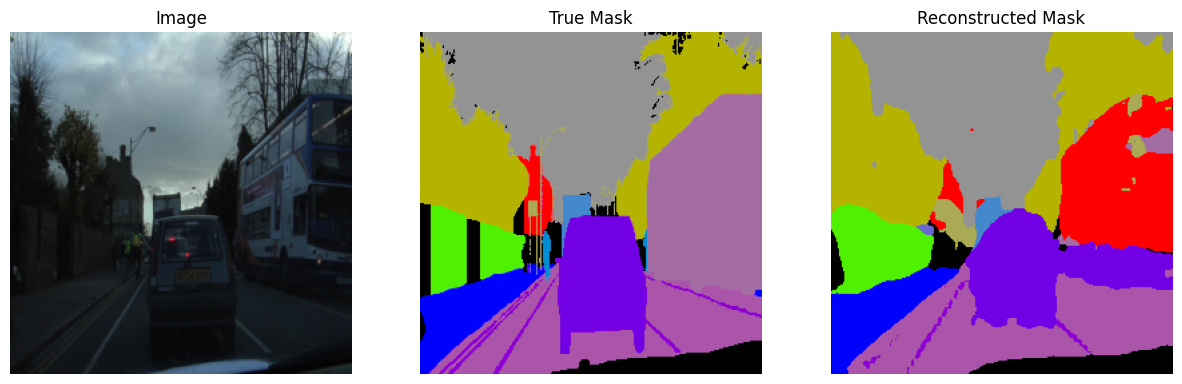

In [344]:
show_random_prediction(val_loader, trained_segformer_model, normalized_unique_colors)

Визуально объекты более размытые, но метрики немного лучше, чем у Unet

# 3. Улучшение бейзлайна
## 3.a. Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)

Проведем эксперименты с аугментированным датасетом.
Применим повороты, отражения, увеличение яркости, размытие по Гауссу и оптическое искажение

In [ ]:
import copy
import albumentations as A

def get_transforms_aug1():
    return A.Compose([
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
        A.HorizontalFlip(p=0.5),
    ])

def get_transforms_aug2():
    return A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    ])

def get_transforms_aug3():
    return A.Compose([
        A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=20, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
        A.HorizontalFlip(p=0.5),
        A.GridDistortion(p=0.3),
        A.OpticalDistortion(p=0.3),
    ])

def experiment_augmentations(train_data, val_data, device='cuda'):
    results = {}
    augmentations = {
        'baseline': None, 
        'aug1': get_transforms_aug1(),
        'aug2': get_transforms_aug2(),
        'aug3': get_transforms_aug3()
    }
    
    for name, aug in augmentations.items():
        print(f"\n=== Эксперимент с аугментацией {name} ===")
        
        aug_train_data = SegmentationDataset(
            train_data.image_dir, 
            train_data.mask_dir,
            transform=train_data.transform,
            mask_transform=train_data.mask_transform,
            aug=aug
        )
        
        train_loader = DataLoader(
            aug_train_data, 
            batch_size=16, 
            shuffle=True, 
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_data, 
            batch_size=16, 
            shuffle=False, 
            num_workers=4,
            pin_memory=True
        )
        
        model = smp.Unet(
            encoder_name='resnet34',
            encoder_weights='imagenet',
            in_channels=3,
            classes=32,
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        model, val_iou = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            criterion=criterion,
            num_epochs=10,
            device=device,
            return_iou=True
        )
        
        results[name] = val_iou
        
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values())
    plt.ylabel('IoU Score')
    plt.xlabel('Augmentation Strategy')
    plt.title('IoU Scores for Different Augmentation Strategies')
    plt.savefig('augmentation_results.png')
    plt.show()
    
    return results



=== Эксперимент с аугментацией baseline ===
Epoch 1/10, Training Loss: 3.1491, Training IoU: 0.0275
Epoch 1/10, Validation Loss: 2.7916, Validation IoU: 0.0532
Epoch 2/10, Training Loss: 2.6130, Training IoU: 0.0899
Epoch 2/10, Validation Loss: 2.3995, Validation IoU: 0.0924
Epoch 3/10, Training Loss: 2.3228, Training IoU: 0.1036
Epoch 3/10, Validation Loss: 2.1605, Validation IoU: 0.0990
Epoch 4/10, Training Loss: 2.0673, Training IoU: 0.1119
Epoch 4/10, Validation Loss: 1.9629, Validation IoU: 0.1048
Epoch 5/10, Training Loss: 1.8306, Training IoU: 0.1178
Epoch 5/10, Validation Loss: 1.8036, Validation IoU: 0.1114
Epoch 6/10, Training Loss: 1.6356, Training IoU: 0.1259
Epoch 6/10, Validation Loss: 1.6059, Validation IoU: 0.1203
Epoch 7/10, Training Loss: 1.4622, Training IoU: 0.1356
Epoch 7/10, Validation Loss: 1.4294, Validation IoU: 0.1228
Epoch 8/10, Training Loss: 1.3221, Training IoU: 0.1401
Epoch 8/10, Validation Loss: 1.3313, Validation IoU: 0.1266
Epoch 9/10, Training Loss: 

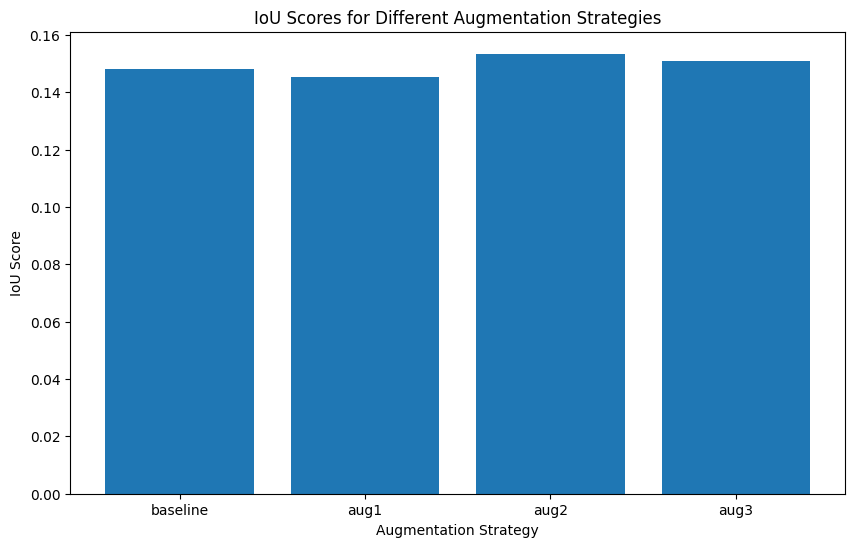

In [ ]:
results = experiment_augmentations(train_dataset, val_dataset)


Незначительно лучше всех себя показала аугментация с размытием по Гауссу. Воспользуемся ей для обучения Segformer

In [384]:
aug_train_data = SegmentationDataset(
    train_dataset.image_dir, 
    train_dataset.mask_dir,
    transform=train_dataset.transform,
    mask_transform=train_dataset.mask_transform,
    aug=get_transforms_aug2(),
)
        
train_loader = DataLoader(
    aug_train_data, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)


model = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=32,
)

aug_trained_segformer_model, iou = train_model(model, train_loader, val_loader, return_iou=True)
print(f'IOU score: {iou}')

Epoch 1/10, Training Loss: 1.5436, Training IoU: 0.0962
Epoch 1/10, Validation Loss: 1.1946, Validation IoU: 0.1157
Epoch 2/10, Training Loss: 0.9903, Training IoU: 0.1385
Epoch 2/10, Validation Loss: 0.9829, Validation IoU: 0.1349
Epoch 3/10, Training Loss: 0.8739, Training IoU: 0.1650
Epoch 3/10, Validation Loss: 0.7505, Validation IoU: 0.1785
Epoch 4/10, Training Loss: 0.7729, Training IoU: 0.1927
Epoch 4/10, Validation Loss: 0.6636, Validation IoU: 0.1964
Epoch 5/10, Training Loss: 0.7158, Training IoU: 0.2090
Epoch 5/10, Validation Loss: 0.7012, Validation IoU: 0.1935
Epoch 6/10, Training Loss: 0.7301, Training IoU: 0.2044
Epoch 6/10, Validation Loss: 0.6486, Validation IoU: 0.1986
Epoch 7/10, Training Loss: 0.6839, Training IoU: 0.2218
Epoch 7/10, Validation Loss: 0.6159, Validation IoU: 0.2131
Epoch 8/10, Training Loss: 0.6547, Training IoU: 0.2282
Epoch 8/10, Validation Loss: 0.6157, Validation IoU: 0.2127
Epoch 9/10, Training Loss: 0.6397, Training IoU: 0.2314
Epoch 9/10, Vali

При помощи аугментаций не удалось улучшить результаты моделей. Вероятно, это связано с небольшим размером датасета

# 4.	Имплементация алгоритма машинного обучения

#### Simple Unet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=32):
        super(SimpleUNet, self).__init__()
        
        features = [64, 128, 256]
        
        self.encoder1 = DoubleConv(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = DoubleConv(features[0], features[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = DoubleConv(features[1], features[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = DoubleConv(features[2], features[2] * 2)
        
        self.upconv3 = nn.ConvTranspose2d(features[2] * 2, features[2], kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(features[2] * 2, features[2])
        
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(features[1] * 2, features[1])
        
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(features[0] * 2, features[0])
        
        self.outconv = nn.Conv2d(features[0], num_classes, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)
        
        enc2 = self.encoder2(x)
        x = self.pool2(enc2)
        
        enc3 = self.encoder3(x)
        x = self.pool3(enc3)
        
        x = self.bottleneck(x)
        
        x = self.upconv3(x)
        diffY = enc3.size()[2] - x.size()[2]
        diffX = enc3.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, enc3], dim=1)
        x = self.decoder3(x)
        
        x = self.upconv2(x)
        diffY = enc2.size()[2] - x.size()[2]
        diffX = enc2.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)
        
        x = self.upconv1(x)
        diffY = enc1.size()[2] - x.size()[2]
        diffX = enc1.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)
        
        return self.outconv(x)


Обучим модель и посмотрим на ее результаты

Epoch 1/10, Training Loss: 2.4101, Training IoU: 0.0592
Epoch 1/10, Validation Loss: 1.7277, Validation IoU: 0.0706
Epoch 2/10, Training Loss: 1.7175, Training IoU: 0.0705
Epoch 2/10, Validation Loss: 1.6341, Validation IoU: 0.0714
Epoch 3/10, Training Loss: 1.4654, Training IoU: 0.0780
Epoch 3/10, Validation Loss: 1.3427, Validation IoU: 0.0794
Epoch 4/10, Training Loss: 1.3684, Training IoU: 0.0839
Epoch 4/10, Validation Loss: 1.2451, Validation IoU: 0.0925
Epoch 5/10, Training Loss: 1.2954, Training IoU: 0.0948
Epoch 5/10, Validation Loss: 1.1458, Validation IoU: 0.1070
Epoch 6/10, Training Loss: 1.2696, Training IoU: 0.0995
Epoch 6/10, Validation Loss: 1.2279, Validation IoU: 0.1094
Epoch 7/10, Training Loss: 1.3176, Training IoU: 0.0977
Epoch 7/10, Validation Loss: 1.1953, Validation IoU: 0.1041
Epoch 8/10, Training Loss: 1.2024, Training IoU: 0.1075
Epoch 8/10, Validation Loss: 1.1944, Validation IoU: 0.1187
Epoch 9/10, Training Loss: 1.1664, Training IoU: 0.1101
Epoch 9/10, Vali

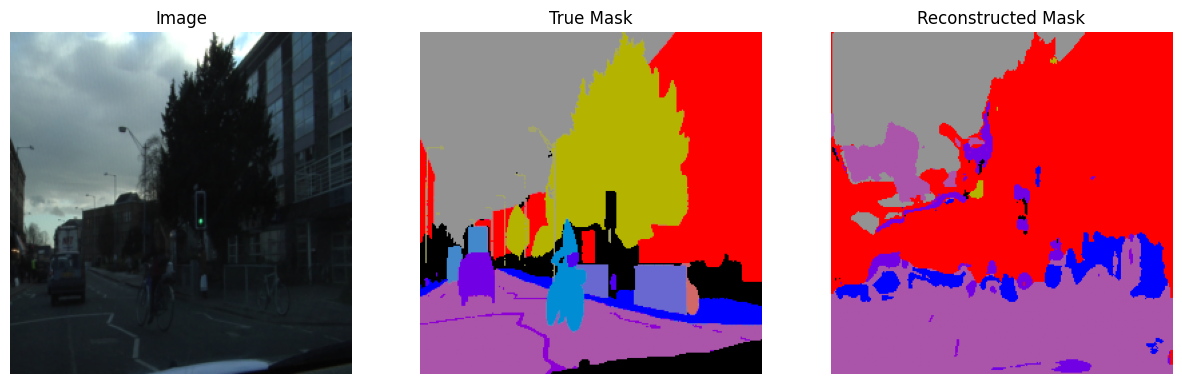

In [389]:
model = SimpleUNet()

model = train_model(model, train_loader, val_loader)
show_random_prediction(val_loader, model, normalized_unique_colors)

Как видно, самописной модели удается угадывать только большие объекты.

#### Transformer

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=16, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        
        self.proj = nn.Conv2d(
            in_channels, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
    
    def forward(self, x):
        x = self.proj(x)
        
        h, w = x.shape[2], x.shape[3]
        
        x = x.flatten(2) 
        x = x.transpose(1, 2) 
        
        return x, (h, w)


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        B, N, C = x.shape
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        
        x = self.proj(x)
        x = self.dropout(x)
        
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=int(dim * mlp_ratio),
            out_features=dim,
            dropout=dropout
        )
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class SegmentationHead(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
    
    def forward(self, x, original_size):
        x = self.conv(x)
        x = F.interpolate(x, size=original_size, mode='bilinear', align_corners=False)
        return x


class SimpleTransformerSegmenter(nn.Module):
    def __init__(self, 
                 patch_size=16, 
                 in_channels=3, 
                 num_classes=32,
                 embed_dim=256, 
                 depth=4, 
                 num_heads=8, 
                 mlp_ratio=4, 
                 dropout=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(patch_size, in_channels, embed_dim)
        
        self.pos_embed_dim = embed_dim
        
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        self.patch_size = patch_size
        
        self.segmentation_head = SegmentationHead(
            in_channels=embed_dim,
            out_channels=num_classes
        )
    
    def get_positional_embeddings(self, h, w, embed_dim):
        grid_h, grid_w = torch.meshgrid(
            torch.arange(h, device=self.device),
            torch.arange(w, device=self.device),
            indexing='ij'
        )
        grid = torch.stack([grid_h, grid_w], dim=-1)
        
        grid = grid.float() / (h - 1)
        grid = grid * 2 - 1
        
        pos_embed = torch.zeros((h * w, embed_dim), device=self.device)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, device=self.device) * -(math.log(10000.0) / embed_dim))
        
        pos_embed[:, 0::2] = torch.sin(grid.view(-1, 2)[:, 0].unsqueeze(1) * div_term)
        pos_embed[:, 1::2] = torch.cos(grid.view(-1, 2)[:, 0].unsqueeze(1) * div_term)
        
        pos_embed = pos_embed.unsqueeze(0)
        
        return pos_embed
    
    @property
    def device(self):
        return next(self.parameters()).device
    
    def forward(self, x):
        original_size = (x.shape[2], x.shape[3])
        
        x, (h, w) = self.patch_embed(x)
        
        pos_embed = self.get_positional_embeddings(h, w, self.pos_embed_dim)
        
        x = x + pos_embed
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        x = x.transpose(1, 2).reshape(
            x.shape[0], 
            -1, 
            h, 
            w
        )
        
        x = self.segmentation_head(x, original_size)
        
        return x


Epoch 1/10, Training Loss: 2.0662, Training IoU: 0.0412
Epoch 1/10, Validation Loss: 1.8337, Validation IoU: 0.0561
Epoch 2/10, Training Loss: 1.7621, Training IoU: 0.0517
Epoch 2/10, Validation Loss: 1.6807, Validation IoU: 0.0566
Epoch 3/10, Training Loss: 1.7108, Training IoU: 0.0546
Epoch 3/10, Validation Loss: 1.6423, Validation IoU: 0.0592
Epoch 4/10, Training Loss: 1.6759, Training IoU: 0.0573
Epoch 4/10, Validation Loss: 1.5844, Validation IoU: 0.0639
Epoch 5/10, Training Loss: 1.5561, Training IoU: 0.0652
Epoch 5/10, Validation Loss: 1.3460, Validation IoU: 0.0699
Epoch 6/10, Training Loss: 1.3974, Training IoU: 0.0751
Epoch 6/10, Validation Loss: 1.2426, Validation IoU: 0.0781
Epoch 7/10, Training Loss: 1.3625, Training IoU: 0.0828
Epoch 7/10, Validation Loss: 1.2107, Validation IoU: 0.0907
Epoch 8/10, Training Loss: 1.3155, Training IoU: 0.0856
Epoch 8/10, Validation Loss: 1.3106, Validation IoU: 0.0901
Epoch 9/10, Training Loss: 1.3774, Training IoU: 0.0807
Epoch 9/10, Vali

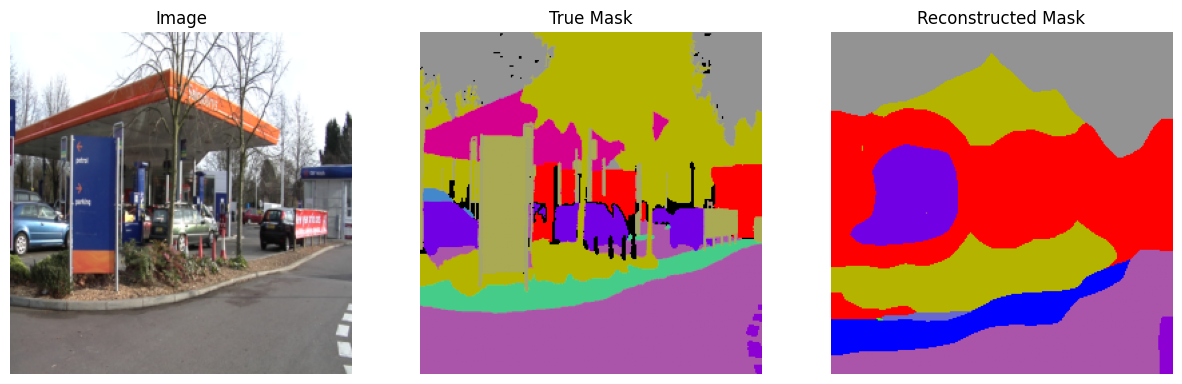

In [394]:
model = SimpleTransformerSegmenter()

model = train_model(model, train_loader, val_loader)
show_random_prediction(val_loader, model, normalized_unique_colors)

Собственная реализация простого трансформера угадывает только очертания объектов, метрика оставляет желать лучшего

Epoch 1/10, Training Loss: 2.2893, Training IoU: 0.0617
Epoch 1/10, Validation Loss: 3.1052, Validation IoU: 0.0465
Epoch 2/10, Training Loss: 1.6322, Training IoU: 0.0771
Epoch 2/10, Validation Loss: 6.9954, Validation IoU: 0.0339
Epoch 3/10, Training Loss: 1.4400, Training IoU: 0.0832
Epoch 3/10, Validation Loss: 1.2791, Validation IoU: 0.0871
Epoch 4/10, Training Loss: 1.3379, Training IoU: 0.0927
Epoch 4/10, Validation Loss: 1.5494, Validation IoU: 0.0662
Epoch 5/10, Training Loss: 1.2789, Training IoU: 0.0973
Epoch 5/10, Validation Loss: 1.7841, Validation IoU: 0.0720
Epoch 6/10, Training Loss: 1.2947, Training IoU: 0.0933
Epoch 6/10, Validation Loss: 1.4214, Validation IoU: 0.0710
Epoch 7/10, Training Loss: 1.2249, Training IoU: 0.1081
Epoch 7/10, Validation Loss: 1.2873, Validation IoU: 0.1098
Epoch 8/10, Training Loss: 1.1857, Training IoU: 0.1106
Epoch 8/10, Validation Loss: 1.0855, Validation IoU: 0.1242
Epoch 9/10, Training Loss: 1.1498, Training IoU: 0.1158
Epoch 9/10, Vali

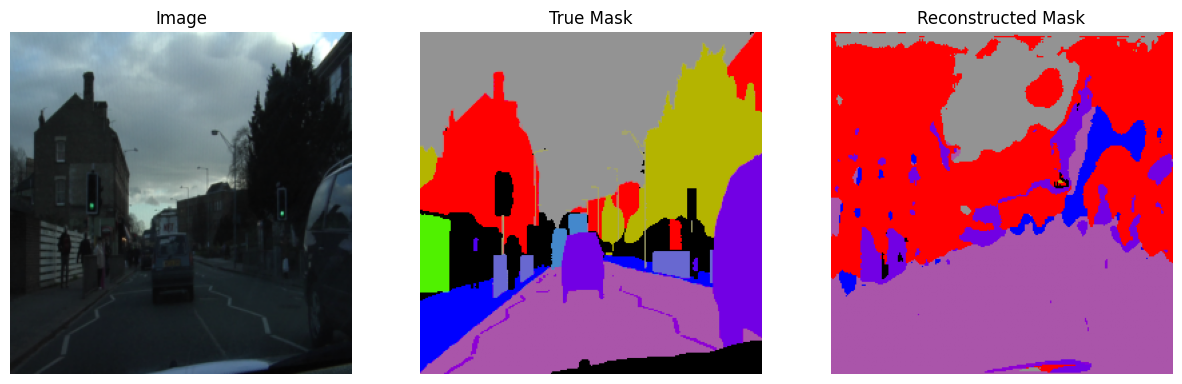

In [396]:
aug_train_data = SegmentationDataset(
    train_dataset.image_dir, 
    train_dataset.mask_dir,
    transform=train_dataset.transform,
    mask_transform=train_dataset.mask_transform,
    aug=get_transforms_aug2(),
)
        
train_loader = DataLoader(
    aug_train_data, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)


model = SimpleUNet()

aug_trained_segformer_model, iou = train_model(model, train_loader, val_loader, return_iou=True)
print(f'IOU score: {iou}')
show_random_prediction(val_loader, model, normalized_unique_colors)

Epoch 1/10, Training Loss: 2.0359, Training IoU: 0.0434
Epoch 1/10, Validation Loss: 1.7140, Validation IoU: 0.0548
Epoch 2/10, Training Loss: 1.7316, Training IoU: 0.0545
Epoch 2/10, Validation Loss: 1.6559, Validation IoU: 0.0588
Epoch 3/10, Training Loss: 1.7071, Training IoU: 0.0552
Epoch 3/10, Validation Loss: 1.5866, Validation IoU: 0.0581
Epoch 4/10, Training Loss: 1.6437, Training IoU: 0.0617
Epoch 4/10, Validation Loss: 1.6632, Validation IoU: 0.0573
Epoch 5/10, Training Loss: 1.4994, Training IoU: 0.0699
Epoch 5/10, Validation Loss: 1.2945, Validation IoU: 0.0737
Epoch 6/10, Training Loss: 1.5051, Training IoU: 0.0713
Epoch 6/10, Validation Loss: 1.3643, Validation IoU: 0.0788
Epoch 7/10, Training Loss: 1.4080, Training IoU: 0.0733
Epoch 7/10, Validation Loss: 1.3445, Validation IoU: 0.0928
Epoch 8/10, Training Loss: 1.3928, Training IoU: 0.0775
Epoch 8/10, Validation Loss: 1.3719, Validation IoU: 0.0871
Epoch 9/10, Training Loss: 1.3590, Training IoU: 0.0871
Epoch 9/10, Vali

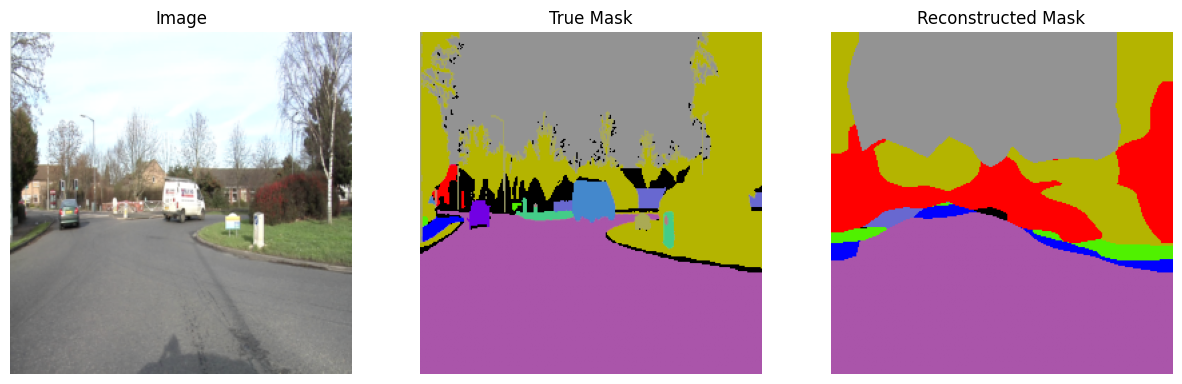

In [27]:
aug_train_data = SegmentationDataset(
    train_dataset.image_dir, 
    train_dataset.mask_dir,
    transform=train_dataset.transform,
    mask_transform=train_dataset.mask_transform,
    aug=get_transforms_aug2(),
)
        
train_loader = DataLoader(
    aug_train_data, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)


model = SimpleTransformerSegmenter()

aug_trained_segformer_model, iou = train_model(model, train_loader, val_loader, return_iou=True)
print(f'IOU score: {iou}')
show_random_prediction(val_loader, model, normalized_unique_colors)

Трансформерная модель снова показала себя хуже, чем Unet. Возможно, для ее обучения требуется кратно больше времени